# Imports

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from darwinian_shift import DarwinianShift, GlobalKmerSpectrum, TranscriptKmerSpectrum, EvenMutationalSpectrum
from darwinian_shift import CDFPermutationTest, ChiSquareTest, PermutationTest
from darwinian_shift import FoldXLookup, SequenceDistanceLookup, MutationExclusionLookup, StructureDistanceLookup
from darwinian_shift import MutationExclusionLookup, ORLookup
from darwinian_shift import hide_top_and_right_axes

In [3]:
from darwinian_shift.additional_plotting_functions import plot_scatter_two_scores

In [4]:
from darwinian_shift.utils.sifts_functions import get_sifts_alignment
import os

# Setup

In [5]:
# Define the region to test
p53_dbd_section = {
    'transcript_id': 'ENST00000269305', 'pdb_id': '2ac0', 'pdb_chain': 'A', 
    'excluded_residues': [292]  # Lys292 is missing from the alpha-carbon in chain A. For consistency between tests, exclude from all
}


In [6]:
# Define the statistical tests

cdf_perm = CDFPermutationTest(num_permutations=100000, testing_random_seed=0)  # Used to calculate p-values

chi_sq = ChiSquareTest(bins=[-0.1, 0.5, 1.1])  # Used to calculate counts for the discrete metrics

stats = [cdf_perm, chi_sq]

In [7]:
# Make a DarwinianShift object for the project. 
# This calculates the mutational spectrum, sets up the statistical tests to use, and filters the data. 
d = DarwinianShift(
    data="SMS-35_merged_sorted.txt", 
    source_genome='GRCh37',
    stats=[cdf_perm, chi_sq],
    spectra=GlobalKmerSpectrum(
        k=3,  # Use a trinucleotide context,
        ignore_strand=False,  # Transcribed strand of the protein matters, so have 192 different mutation types
        deduplicate_spectrum=False,  # Do not remove duplicate mutations when calculating the spectrum
        name=''  # Use a blank name, so in the plots it will just say "Expected"
    ),
    # Just test with the missense mutations. Nonsense and synonymous mutations are still used to calculate the spectrum
    included_mutation_types='missense'
)

/Users/mh28/miniconda3/envs/ds/lib/python3.8/subprocess.py:849: RuntimeWarning: line buffering (buffering=1) isn't supported in binary mode, the default buffer size will be used
  self.stderr = io.open(errread, 'rb', bufsize)


In [8]:
plot_directory="."
    
sifts_directory="."
pdb_directory = "."

In [9]:
# Colours

unobserved_colour = '#BBBBBB'  
observed_colour = '#EE7733'

foldx_expected_colour = '#EE6677'
foldx_observed_colour = '#CC3311'

interface_expected_colour = '#88CCEE'
interface_observed_colour = '#0077BB'

calcium_expected_colour = '#8DE0D7'
calcium_observed_colour = '#009988'

# Results

## Defining metrics

In [10]:
# Define the FoldX lookup
fold = FoldXLookup(foldx_results_directory="./FoldX_results",
                      sifts_directory=sifts_directory,
                      foldx_file_name_start="PS_f*", download_sifts=True)

In [11]:
target_selection_string = 'segid E F G H'
p53_dbd_section['DNA_target'] = target_selection_string

In [12]:
# Define a lookup object which measures distance from the DNA
interface_lookup = StructureDistanceLookup(
    boolean=False,  
    target_key='DNA_target',   # Use this entry in the section_definition dict to define the target residues
    name='Distance from DNA (A)',  # Label to appear on plot axes
    distance_to_alpha_carbons=True,
    
    # Uses the pdb file and SIFTS. Provide paths to directories including those files.
    pdb_directory=pdb_directory,
    sifts_directory=sifts_directory, 
    download_sifts=True   # Download the SIFTS file if not already in the directory
)

## Statistical tests

### FoldX

In [13]:
excllook_foldx = MutationExclusionLookup(
    lookup=fold,   # Use the calcium binding lookup for the test
    exclusion_lookup=interface_lookup,
    exclusion_threshold=5,  
    exclusion_direction=-1,  
    name=fold.name
)

In [14]:
d_fold = d.change_lookup(excllook_foldx)

In [15]:
s_fold_p53 = d_fold.run_section(p53_dbd_section, statistics=[cdf_perm])

/Users/mh28/PycharmProjects/darwinian_shift/darwinian_shift/lookup_classes/combination_lookup.py:139: RuntimeWarning: invalid value encountered in less
  excluded_muts = exclusion_scores < self.exclusion_threshold


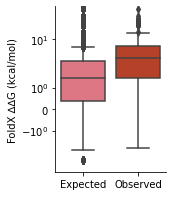

In [16]:
s_fold_p53.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[foldx_observed_colour, foldx_expected_colour])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'p53_box_plot_foldX.pdf'), transparent=True)

In [17]:
s_fold_p53.get_pvalues()

{'CDF_perm__pvalue': 1.999980000199998e-05}

In [18]:
s_fold_p53.num_mutations

760

### Interface

In [19]:
excllook_interface = MutationExclusionLookup(
    lookup=interface_lookup,   # Use the calcium binding lookup for the test
    exclusion_lookup=fold,
    exclusion_threshold=2,  
    exclusion_direction=1,  
    name=interface_lookup.name
)

In [20]:
d_interface = d.change_lookup(excllook_interface)

In [21]:
s_interface_p53 = d_interface.run_section(p53_dbd_section, statistics=[cdf_perm])

/Users/mh28/PycharmProjects/darwinian_shift/darwinian_shift/lookup_classes/combination_lookup.py:136: RuntimeWarning: invalid value encountered in greater
  excluded_muts = exclusion_scores > self.exclusion_threshold


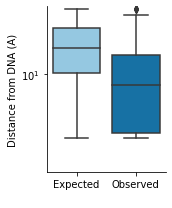

In [22]:
s_interface_p53.plot_boxplot(figsize=(2.5, 3), plot_scale='symlog',
                    colours=[interface_observed_colour, interface_expected_colour])
hide_top_and_right_axes()
plt.tight_layout()
plt.savefig(os.path.join(plot_directory, 'p53_box_plot_interface.pdf'), transparent=True)

In [23]:
s_interface_p53.get_pvalues()

{'CDF_perm__pvalue': 1.999980000199998e-05}

In [24]:
s_interface_p53.num_mutations

395